In [15]:
#!/usr/bin/env python
# coding: utf-8

%load_ext autoreload
%autoreload 2



import torch, datetime, click
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
from utils import *
from data_mgmt import get_paths, get_ids
from predict import Prior

from plot import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
DEVICE = 'cuda'



m = 1
nsub = 1
nsim = 500

nmc = 3
sigma = 0.0

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 10

zero = 'real'

In [17]:

def noise(obs, _= None, sigma_n = sigma):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}

# Set definitions (should go to click)
systemname = "ngc4414"

# Set utilities

store_path, dataset_path, mre_path, _ = get_paths(dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,zero=zero))

store = swyft.Store.load(path=store_path)
print(f'Store has {len(store)} simulations.')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
config = get_config(systemname, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

dataset = swyft.Dataset(nsim, prior, store, simhook = noise)


Loading existing store.
Store has 445 simulations.
Image has L = 40.


In [22]:
time_start = datetime.datetime.now()

    
class CustomMarginalClassifier(torch.nn.Module):
    def __init__(self, n_marginals: int, n_features: int, nsub, nmc, lows, highs, L):
        super().__init__()
                
        self.n_marginals = n_marginals

        
        self.n_features = n_features.item() #n_features
        self.L = int(np.sqrt(self.n_features).item())
        
        self.nmc = nmc
        
        self.UNet = UNET(in_channels = 1, out_channels = self.nmc)
        
        prior = Prior( nsub, nmc, lows, highs, L)
        _, _, self.priors = prior()
        
                
    def forward(self, sims: torch.Tensor, target_map: torch.Tensor) -> torch.Tensor:
        
        sims = sims.view(-1, self.L, self.L)
        
#         def get_priors(nsub = 1, L = 40, nmc = 1):
#             prior = nsub/(L*L)/nmc
#             prior0 = 1 - prior
#             prior1 = prior
#             return prior0, prior1, np.repeat(np.array([prior0, prior1]), nmc) 
#         prior0, prior1, _ = get_priors()

        
        x = self.UNet(sims)
        print(x.shape, target_map.shape)
        
        post1_norm = torch.sigmoid(x) 
        post0_norm = 1-post1_norm
        
        print(post1_norm.shape)
        

        x = x*target_map
        x = x.view(x.shape[0], self.nmc, 2, self.L, self.L)
        x = torch.sum(x, axis = 2)
        



        
        

        ##### Christoph's new suggestion #####
#         x = torch.exp(x) 
#         post1 = x * prior1
#         post1_norm = torch.sigmoid(x) 
# #         post1_norm = post1 
#         post0_norm = 1-post1_norm
                
#         x1 = post1_norm / prior1
#         x0 = post0_norm / prior0
        
#         x = torch.stack((x0, x1), dim = 1)
#         x = torch.log(x)  
        
#         x = x.squeeze()


        
        return x.view(-1, self.n_features * self.nmc)

# Train network
print(f'Training {mre_path}!')

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    nsub, nmc, lows, highs, L,
#     L = L,
#     nmc = nmc, 
#     lows = lows,
#     highs = highs,
    marginal_classifier = CustomMarginalClassifier, #(nsub, nmc, lows, highs, L),
    parameter_transform = CustomParameterTransform(nmc, L, lows, highs),
)

mre = swyft.MarginalRatioEstimator(
    marginal_indices = marginal_indices,
    network = network,
    device = DEVICE,
)

_ = mre.train(dataset, max_epochs = max_epochs)

# mre.save(mre_path)
# dataset.save(dataset_path)
duration = str(datetime.datetime.now() - time_start).split('.')[0]
print(f" Training Done! \n Total training time is {duration}! \n \n ")

SyntaxError: positional argument follows keyword argument (3501568480.py, line 87)

# Predict

In [72]:
npred = 0
entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero=zero)
store_path, dataset_path, mre_path, pred_path = get_paths(entry)

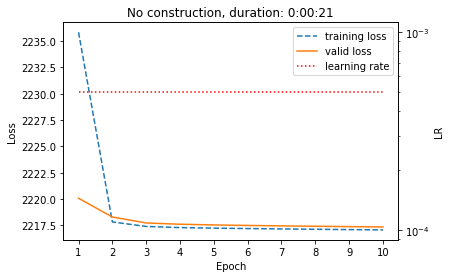

In [73]:
plot_losses(mre, save_name = get_ids(entry)[2], title = f'No construction, duration: {duration}')

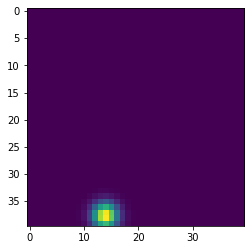

In [75]:
def get_obs(dataset, obs0_i = -1):
    obs0_i = np.random.randint(0, len(dataset)) if obs0_i == -1 else obs0_i

    obs0 = dataset[obs0_i][0]
    v0 = dataset[obs0_i][2]

    obs0['image'] = obs0['image'].unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = v0.unsqueeze(0).to(DEVICE)

    return obs0, v0, obs0_i

def get_empty_and_full_coords(lows, highs, nmc, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmc+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    coord_full = torch.cat( [torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1) for m in ms] ).reshape(1, -1).to(DEVICE, dtype = torch.float)

    return coord_empty, coord_full

obs0, v0, obs0_i = get_obs(dataset)
targets = mre.network.parameter_transform(v0).squeeze()
target = targets.numpy()
plt_imshow(obs0['image'], y = 4)

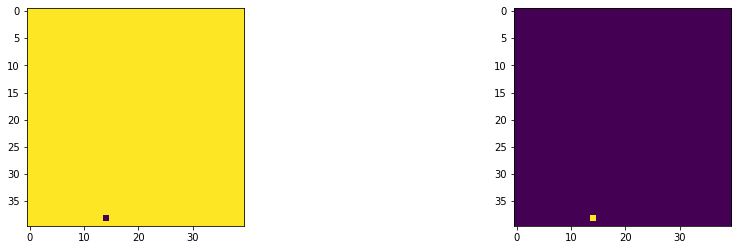

In [76]:
plt_imshow(target, y = 4)

In [77]:
coord_empty, coord_full = get_empty_and_full_coords(lows, highs, nmc, L)

In [78]:
def get_priors(nsub = 1, L = 40, nmc = 1):
    prior = nsub/(L*L)/nmc
    prior0 = 1 - prior
    prior1 = prior
    return prior0, prior1, np.repeat(np.array([prior0, prior1]), nmc) 
prior0, prior1, _ = get_priors()


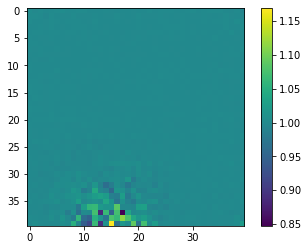

In [79]:
# plt.imshow(np.exp(mre.network(obs0, coord_empty).view(2*nmc, L, L)[0])*prior0 + np.exp(mre.network(obs0, coord_full).view(2*nmc, L, L)[1])*prior1)
plt.imshow(np.exp(mre.network(obs0, coord_empty).view(nmc, L, L)[0])*prior0 + np.exp(mre.network(obs0, coord_full).view(nmc, L, L)[0])*prior1)
plt.colorbar()

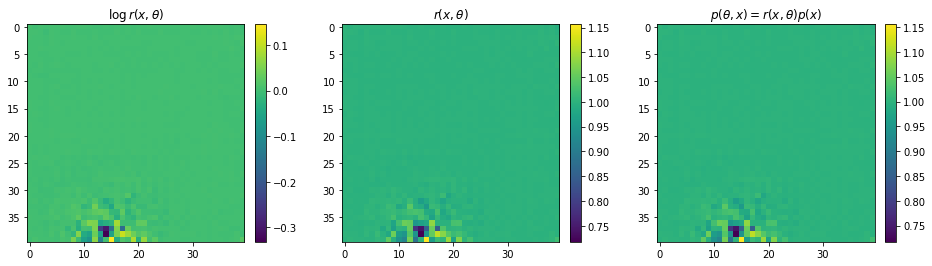

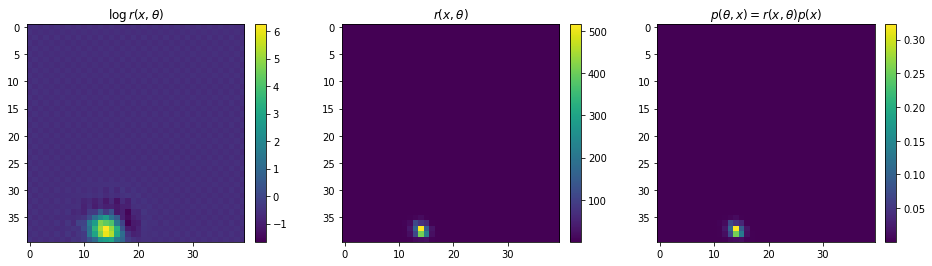

In [80]:
for coord, prior in zip([coord_empty, coord_full], [prior0, prior1]):
    
    
    logratio = mre.network(obs0, coord).view(nmc, L, L)[0]
    
    plt_imshow(
        [logratio, np.exp(logratio), np.exp(logratio)*prior],
        titles = [r'$\log r(x,\theta)$', r'$r(x,\theta)$', r'$p(\theta,x) = r(x,\theta) p(x)$'],
        cbar = True, y = 4)


In [43]:
# for coord, prior in zip([coord_empty, coord_full], [prior0, prior1]):
#     logratio = mre.network(obs0, coord).view(2*nmc, L, L)[0]
    
#     plt_imshow(
#         [logratio, np.exp(logratio), np.exp(logratio)*prior],
#         titles = [r'$\log r(x,\theta)$', r'$r(x,\theta)$', r'$p(\theta,x) = r(x,\theta) p(x)$'],
#         cbar = True, y = 4)
